# Dynamic Asset Allocation Model Using Traditional methods assisted via Random Forest

This notebook implements a sophisticated dynamic asset allocation model that combines machine learning predictions with traditional financial metrics to optimize portfolio performance across multiple asset classes.


In [13]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import time
import logging
from datetime import datetime

# Basic logging setup
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(message)s',
    datefmt='%H:%M:%S'
)

## Data Loading and Asset Class Definition

We begin by loading the processed financial data and defining our asset class universe. The dataset includes various financial instruments across different asset classes, including:
- US Large Cap Equities
- US Technology Stocks
- Commodities
- Real Estate
- Cryptocurrencies (Major and Alt coins)

In [14]:
# Load the data
print("Loading data...")
data = pd.read_csv('data/processed/merged_data.csv', parse_dates=['Date'], index_col='Date')
print(f"Data loaded with shape: {data.shape}")

data = data[data.index.year >= 2016].copy()

# Define asset classes
asset_classes = {
    'us_large_cap': ['SPY_Close', 'QQQ_Close'],
    'us_tech': ['MSFT_Close', 'AMZN_Close', 'GOOGL_Close', 'TSLA_Close'],
    'commodities': ['GC=F_Close', 'CL=F_Close', 'SI=F_Close'],
    'real_estate': ['VNQ_Close', 'SCHH_Close', 'IYR_Close'],
    'crypto_major': ['BTC_Close', 'ETH_Close'],
    'crypto_alt': ['LTC_Close']
}

Loading data...
Data loaded with shape: (5113, 30)


## Feature Engineering

This section implements sophisticated feature engineering for our machine learning model. We calculate various technical and fundamental indicators including:
- Price momentum features (1-day, 5-day, 20-day returns)
- Volatility metrics (20-day and 60-day)
- Technical indicators (RSI, Moving Average Crossovers)
- Momentum and mean reversion signals
- Volatility regime indicators

In [15]:
def calculate_rsi(prices, periods=14):
    """Calculate RSI technical indicator."""
    returns = prices.diff()
    pos = returns.clip(lower=0).ewm(span=periods).mean()
    neg = (-returns.clip(upper=0)).ewm(span=periods).mean()
    rs = pos/neg
    return 100 - (100/(1 + rs))

def create_features(data):
    """Create sophisticated features for the model."""
    # Initialize empty dictionaries to store features
    feature_dicts = {
        'ret_1d': {},
        'ret_5d': {},
        'ret_20d': {},
        'vol_20d': {},
        'vol_60d': {},
        'rsi': {},
        'ma_cross': {},
        'mom_20d': {},
        'mom_60d': {},
        'vol_regime': {}
    }
    
    # Calculate features for each column
    for column in data.columns:
        prices = data[column]
        returns = prices.pct_change()
        
        # Price momentum features
        feature_dicts['ret_1d'][f'{column}_ret_1d'] = returns
        feature_dicts['ret_5d'][f'{column}_ret_5d'] = returns.rolling(5).mean()
        feature_dicts['ret_20d'][f'{column}_ret_20d'] = returns.rolling(20).mean()
        
        # Volatility features
        feature_dicts['vol_20d'][f'{column}_vol_20d'] = returns.rolling(20).std()
        feature_dicts['vol_60d'][f'{column}_vol_60d'] = returns.rolling(60).std()
        
        # Technical indicators
        feature_dicts['rsi'][f'{column}_rsi'] = calculate_rsi(prices)
        feature_dicts['ma_cross'][f'{column}_ma_cross'] = (prices.rolling(10).mean() / 
                                                          prices.rolling(30).mean() - 1)
        
        # Momentum and mean reversion
        feature_dicts['mom_20d'][f'{column}_mom_20d'] = prices.pct_change(20)
        feature_dicts['mom_60d'][f'{column}_mom_60d'] = prices.pct_change(60)
        
        # Volatility regime
        feature_dicts['vol_regime'][f'{column}_vol_regime'] = (returns.rolling(20).std() / 
                                                              returns.rolling(60).std())
    
    # Combine all features at once using concat
    features = pd.concat([pd.DataFrame(d) for d in feature_dicts.values()], axis=1)
    features.index = data.index
    
    return features.dropna()

# Create features
features = create_features(data)
print("Features shape:", features.shape)

Features shape: (1217, 300)


## Model Implementation

We implement a Random Forest Regressor model with the following characteristics:
- 500 decision trees
- Maximum depth of 20 levels
- Bootstrap sampling with 80% of data
- Parallel processing for optimal performance

In [16]:
def train_models(data, features):
    # Initialize scaler and models
    scaler = StandardScaler()
    models = {}

    # Prepare targets for each asset
    targets = {}
    for asset in data.columns:
        if '_Close' in asset:  # Only use closing prices
            asset_name = asset.replace('_Close', '')
            targets[asset_name] = data[asset].pct_change(21).shift(-21).dropna()

    # Find common valid indices across all targets
    valid_indices = features.index
    for target in targets.values():
        valid_indices = valid_indices.intersection(target.index)

    # Prepare scaled features
    X = features.loc[valid_indices]
    X_scaled = scaler.fit_transform(X)

    # Train a model for each asset
    print("Training Random Forest models...")
    start_time = time.time()

    for asset_name, target in targets.items():
        print(f"\nTraining model for {asset_name}...")
        
        # Get target values
        y = target.loc[valid_indices]
        
        # Initialize model with improved parameters
        models[asset_name] = RandomForestRegressor(
            n_estimators=1000,  # Increased number of trees
            max_depth=25,       # Slightly deeper trees
            min_samples_split=5,
            min_samples_leaf=2, # Increased to reduce overfitting
            max_features='sqrt',
            n_jobs=-1,
            random_state=42,
            bootstrap=True,
            max_samples=0.8,
            verbose=0          # Reduced verbosity since we're training multiple models
        )
        
        # Train model
        models[asset_name].fit(X_scaled, y)

    training_time = time.time() - start_time
    print(f"\nAll models training completed in {training_time:.2f} seconds")
    
    return models, scaler, valid_indices

# Train the models
models, scaler, valid_indices = train_models(data, features)

Training Random Forest models...

Training model for MSFT...

Training model for AMZN...

Training model for GOOGL...

Training model for TSLA...

Training model for SPY...

Training model for QQQ...

Training model for XLK...

Training model for XLV...

Training model for XLF...

Training model for ^GSPC...

Training model for ^IXIC...

Training model for ^DJI...

Training model for ^RUT...

Training model for ^TNX...

Training model for IEF...

Training model for TLT...

Training model for GC=F...

Training model for CL=F...

Training model for SI=F...

Training model for VNQ...

Training model for SCHH...

Training model for IYR...

Training model for BTC...

Training model for ETH...

Training model for LTC...

All models training completed in 72.42 seconds


In [17]:
def get_predictions(models, features, scaler):
    """Get predictions for all assets."""
    X_scaled = scaler.transform(features)
    predictions = {}
    
    for asset_name, model in models.items():
        pred = model.predict(X_scaled)
        predictions[asset_name] = pred
        
    return predictions

# Add this function to help with prediction analysis
def analyze_predictions(predictions, asset_classes):
    """Analyze predictions by asset class."""
    analysis = {}
    
    for asset_class, assets in asset_classes.items():
        asset_preds = []
        for asset in assets:
            asset_name = asset.replace('_Close', '')
            if asset_name in predictions:
                asset_preds.append(predictions[asset_name])
        
        if asset_preds:
            analysis[asset_class] = {
                'mean_prediction': np.mean(asset_preds),
                'std_prediction': np.std(asset_preds),
                'max_prediction': np.max(asset_preds),
                'min_prediction': np.min(asset_preds)
            }
    
    return analysis

## Feature Importance Analysis

Visualizing the most influential features in our model helps us understand which factors drive asset returns and allocation decisions.

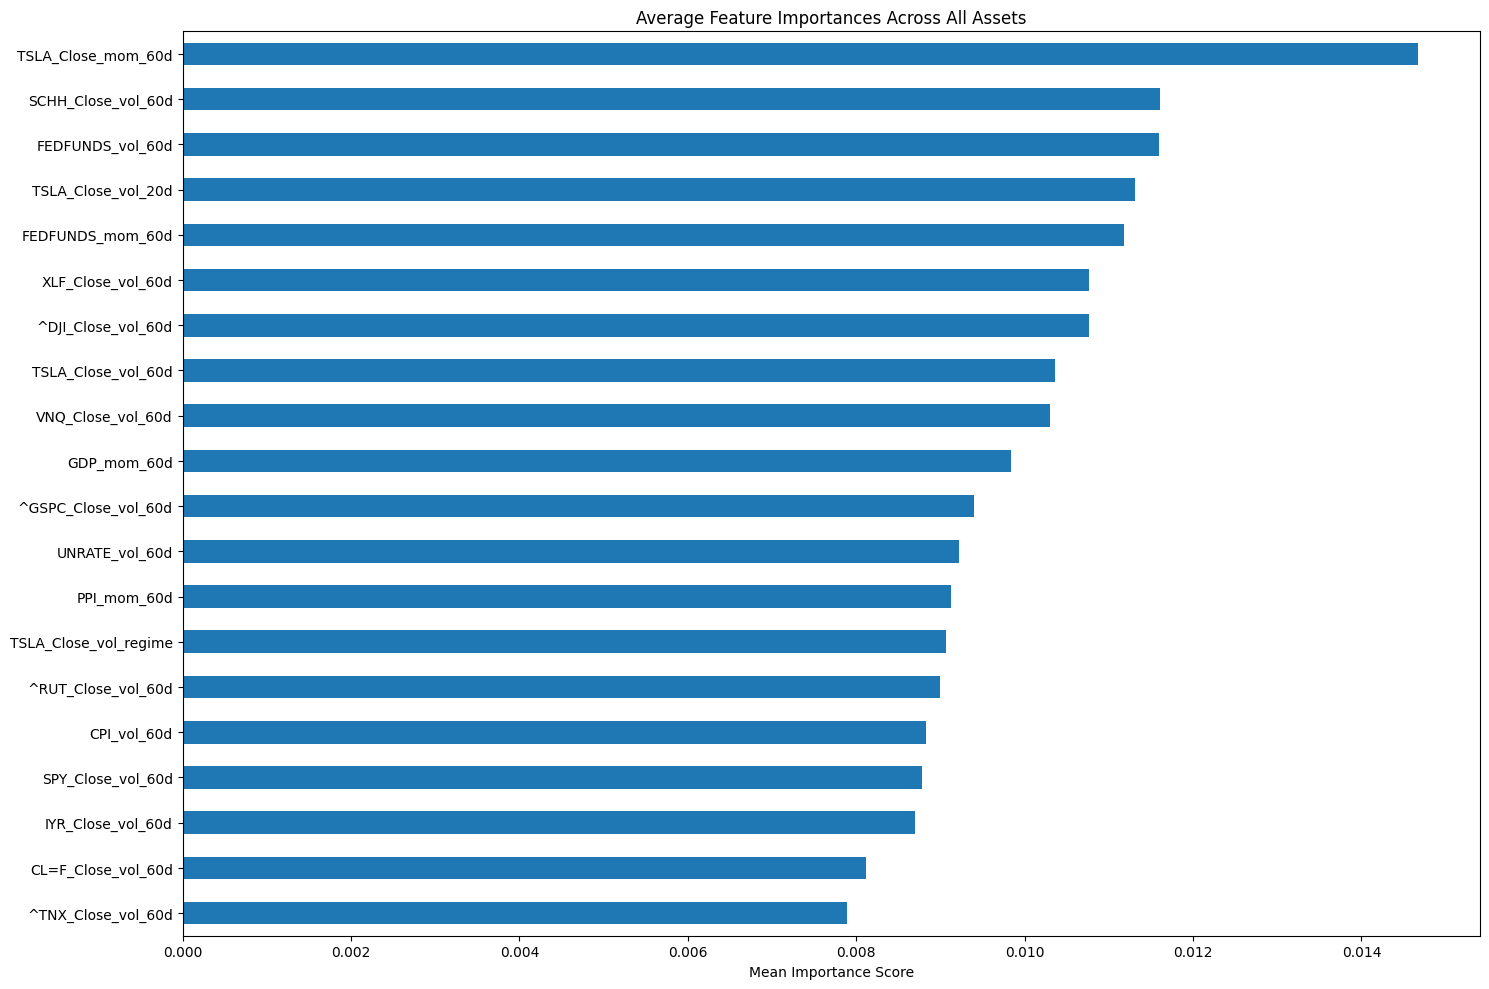

In [18]:
def plot_feature_importances(models, features, top_n=20):
    """Plot feature importances for all models."""
    plt.figure(figsize=(15, 10))
    
    # Calculate average feature importance across all models
    all_importances = pd.DataFrame()
    for asset_name, model in models.items():
        importances = pd.Series(
            model.feature_importances_,
            index=features.columns,
            name=asset_name
        )
        all_importances[asset_name] = importances
    
    # Calculate mean importance across all models
    mean_importances = all_importances.mean(axis=1).sort_values(ascending=True)[-top_n:]
    
    # Plot
    mean_importances.plot(kind='barh')
    plt.title('Average Feature Importances Across All Assets')
    plt.xlabel('Mean Importance Score')
    plt.tight_layout()
    plt.show()
    
    # Optionally, plot individual asset importances
    # plt.figure(figsize=(15, 6 * len(models)))
    # for i, (asset_name, model) in enumerate(models.items(), 1):
    #     plt.subplot(len(models), 1, i)
    #     importances = pd.Series(
    #         model.feature_importances_,
    #         index=features.columns
    #     ).sort_values(ascending=True)[-top_n:]
    #     importances.plot(kind='barh')
    #     plt.title(f'Feature Importances for {asset_name}')
    #     plt.xlabel('Importance Score')
    # plt.tight_layout()
    # plt.show()

# Plot feature importances for all models
plot_feature_importances(models, features)  # Use 'features' instead of 'X'

## Dynamic Weight Calculation

This section implements the core portfolio allocation strategy. The algorithm:
1. Calculates yearly weights for each asset class
2. Incorporates multiple factors:
   - Sharpe ratio (35% weight)
   - Momentum signals (25% weight)
   - Volatility scores (15% weight)
   - Trend indicators (15% weight)
   - Drawdown protection (10% weight)
3. Applies dynamic constraints based on market conditions

In [19]:
def calculate_ml_score(year_features, assets, ml_predictions):
    """Calculate ML score for an asset class."""
    if year_features.empty:
        return 0
    
    # Get predictions for each asset in the asset class
    class_predictions = []
    for asset in assets:
        asset_name = asset.replace('_Close', '')
        if asset_name in ml_predictions:
            pred = ml_predictions[asset_name]
            class_predictions.append(pred)
    
    if not class_predictions:
        return 0
    
    # Calculate the average prediction
    avg_prediction = np.mean(class_predictions)
    
    # Convert prediction to a score between 0 and 1
    # Since predictions are forward returns, we normalize them
    ml_score = 0.5 * (1 + avg_prediction)
    
    return ml_score

def calculate_yearly_weights(data, asset_classes, models, features, scaler):
    """Calculate dynamic weights for each asset class by year."""
    print("\nCalculating yearly weights...")
    
    yearly_weights = {}
    yearly_metrics = {}
    
    for year in range(2016, 2024):
        year_data = data[data.index.year == year]
        
        if not year_data.empty:
            weights = {}
            metrics = {}
            
            # Get ML predictions for this year
            year_features = features[features.index.year == year]
            ml_predictions = {}
            
            if not year_features.empty:
                X_scaled = scaler.transform(year_features)
                
                # Get predictions for each asset
                for asset_name, model in models.items():
                    predictions = model.predict(X_scaled)
                    ml_predictions[asset_name] = predictions.mean()
            
            for asset_class, assets in asset_classes.items():
                # Get asset data
                asset_data = year_data[assets]
                returns = asset_data.pct_change()
                
                # Calculate traditional metrics
                avg_returns = returns.mean()
                risk = returns.std()
                sharpe = (avg_returns / (risk + 1e-6)).mean()
                momentum = returns.ewm(span=60).mean().iloc[-1] if len(returns) > 60 else returns.mean()
                momentum = momentum.mean()
                vol_score = 1 / (risk.mean() + 1e-6)
                
                # Calculate trend
                prices = asset_data.mean(axis=1)
                trend = (prices.iloc[-1] / prices.iloc[0] - 1) if len(prices) > 1 else 0
                
                # Calculate drawdown
                rolling_max = prices.rolling(window=252, min_periods=1).max()
                drawdown = (prices - rolling_max) / rolling_max
                max_drawdown = drawdown.min()
                
                # Get ML prediction score for this asset class
                ml_score = calculate_ml_score(year_features, assets, ml_predictions)
                
                # Combine scores with ML predictions
                combined_score = (
                    0.25 * sharpe +           
                    0.20 * momentum +         
                    0.15 * vol_score +
                    0.10 * trend +            
                    0.10 * (1 + max_drawdown) +
                    0.20 * ml_score          # ML component (20% weight)
                )
                
                weights[asset_class] = max(0, combined_score)
                metrics[asset_class] = {
                    'sharpe': sharpe,
                    'momentum': momentum,
                    'volatility': risk.mean(),
                    'trend': trend,
                    'max_drawdown': max_drawdown,
                    'ml_prediction': ml_score
                }
                
                # Print analysis for each asset class
                print(f"\n{asset_class} Analysis for {year}:")
                print(f"ML Score: {ml_score:.4f}")
                print(f"Combined Score: {combined_score:.4f}")
            
            # Apply dynamic constraints
            bull_markets = [2017, 2019, 2021]
            bear_markets = [2018, 2020, 2022]
            
            for asset_class in weights:
                base_weight = weights[asset_class]
                
                if year in bull_markets:
                    if asset_class in ['us_tech', 'crypto_major']:
                        min_alloc, max_alloc = 0.10, 0.40
                    else:
                        min_alloc, max_alloc = 0.05, 0.30
                elif year in bear_markets:
                    if asset_class in ['commodities', 'us_large_cap']:
                        min_alloc, max_alloc = 0.15, 0.40
                    else:
                        min_alloc, max_alloc = 0.05, 0.25
                else:
                    min_alloc, max_alloc = 0.10, 0.35
                
                weights[asset_class] = max(min_alloc, min(base_weight, max_alloc))
            
            # Normalize weights
            total_weight = sum(weights.values())
            weights = {k: v / total_weight for k, v in weights.items()}
            
            yearly_weights[year] = weights
            yearly_metrics[year] = metrics
            
            print(f"\nYear {year} allocations:")
            for asset_class, weight in sorted(weights.items(), key=lambda x: x[1], reverse=True):
                print(f"{asset_class:<15}: {weight:.2%}")
    
    return yearly_weights, yearly_metrics

# Calculate weights
yearly_weights, yearly_metrics = calculate_yearly_weights(data, asset_classes, models, features, scaler)


Calculating yearly weights...

us_large_cap Analysis for 2016:
ML Score: 0.0000
Combined Score: 19.6416

us_tech Analysis for 2016:
ML Score: 0.0000
Combined Score: 10.3986

commodities Analysis for 2016:
ML Score: 0.0000
Combined Score: 9.6057

real_estate Analysis for 2016:
ML Score: 0.0000
Combined Score: 17.1071


KeyError: "None of [Index(['BTC-USD_Close', 'ETH-USD_Close'], dtype='object')] are in the [columns]"

## Portfolio Performance Calculation

Calculate the portfolio's historical performance using the dynamic weights generated for each asset class.

In [9]:
def calculate_portfolio_performance(data, yearly_weights, asset_classes, yearly_metrics):
    """Calculate portfolio performance with ML insights."""
    portfolio_returns = pd.DataFrame(index=data.index)
    ml_signals = pd.DataFrame(index=data.index)
    
    # Calculate portfolio returns
    for year in yearly_weights:
        year_data = data[data.index.year == year]
        weights = yearly_weights[year]
        metrics = yearly_metrics[year]
        
        year_returns = pd.DataFrame(index=year_data.index)
        for asset_class, assets in asset_classes.items():
            # Calculate returns
            asset_returns = year_data[assets].pct_change().mean(axis=1) * weights[asset_class]
            year_returns[asset_class] = asset_returns
            
            # Store ML signals
            if asset_class in metrics:
                ml_signals.loc[year_data.index, asset_class] = metrics[asset_class]['ml_prediction']
        
        portfolio_returns.loc[year_data.index, 'Portfolio'] = year_returns.sum(axis=1)
    
    # Calculate cumulative returns
    portfolio_returns['Cumulative'] = (1 + portfolio_returns['Portfolio']).cumprod()
    
    return portfolio_returns, ml_signals

## Performance Metrics Analysis

Comprehensive evaluation of the portfolio's performance using various metrics:
- Annual returns and volatility
- Risk-adjusted measures (Sharpe and Sortino ratios)
- Maximum drawdown
- Win rate and monthly statistics

In [10]:
def calculate_performance_metrics(portfolio_returns):
    """Calculate comprehensive performance metrics."""
    # Basic metrics
    annual_return = portfolio_returns['Portfolio'].mean() * 252
    annual_vol = portfolio_returns['Portfolio'].std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_vol
    
    # Calculate drawdown
    cum_returns = portfolio_returns['Cumulative']
    rolling_max = cum_returns.expanding().max()
    drawdowns = (cum_returns - rolling_max) / rolling_max
    max_drawdown = drawdowns.min()
    
    # Calculate monthly returns
    monthly_returns = portfolio_returns['Portfolio'].resample('ME').apply(lambda x: (1 + x).prod() - 1)
    
    # Calculate win rate
    winning_months = (monthly_returns > 0).sum()
    total_months = len(monthly_returns)
    win_rate = winning_months / total_months
    
    # Calculate Sortino ratio
    downside_returns = portfolio_returns['Portfolio'][portfolio_returns['Portfolio'] < 0]
    downside_std = downside_returns.std() * np.sqrt(252)
    sortino_ratio = annual_return / downside_std if downside_std != 0 else np.nan
    
    metrics = {
        'Annual Return': annual_return,
        'Annual Volatility': annual_vol,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Max Drawdown': max_drawdown,
        'Win Rate': win_rate,
        'Best Month': monthly_returns.max(),
        'Worst Month': monthly_returns.min()
    }
    
    return metrics

# First, calculate portfolio performance
portfolio_returns, ml_signals = calculate_portfolio_performance(
    data, yearly_weights, asset_classes, yearly_metrics
)


# Calculate performance metrics
performance_metrics = calculate_performance_metrics(portfolio_returns)

# Display metrics
print("\nPortfolio Performance Metrics:")
print("=" * 40)
for metric, value in performance_metrics.items():
    if isinstance(value, float):
        print(f"{metric:<20}: {value:>10.2%}")
    else:
        print(f"{metric:<20}: {value:>10.2f}")


Portfolio Performance Metrics:
Annual Return       :      7.95%
Annual Volatility   :     18.13%
Sharpe Ratio        :     43.86%
Sortino Ratio       :     33.76%
Max Drawdown        :    -53.64%
Win Rate            :     67.71%
Best Month          :     12.82%
Worst Month         :    -28.56%


## Visualization and Analysis

Three key visualizations to analyze the portfolio's behavior:
1. Portfolio Performance vs S&P 500 Benchmark
2. Dynamic Asset Allocation Over Time
3. Asset Class Correlation Matrix

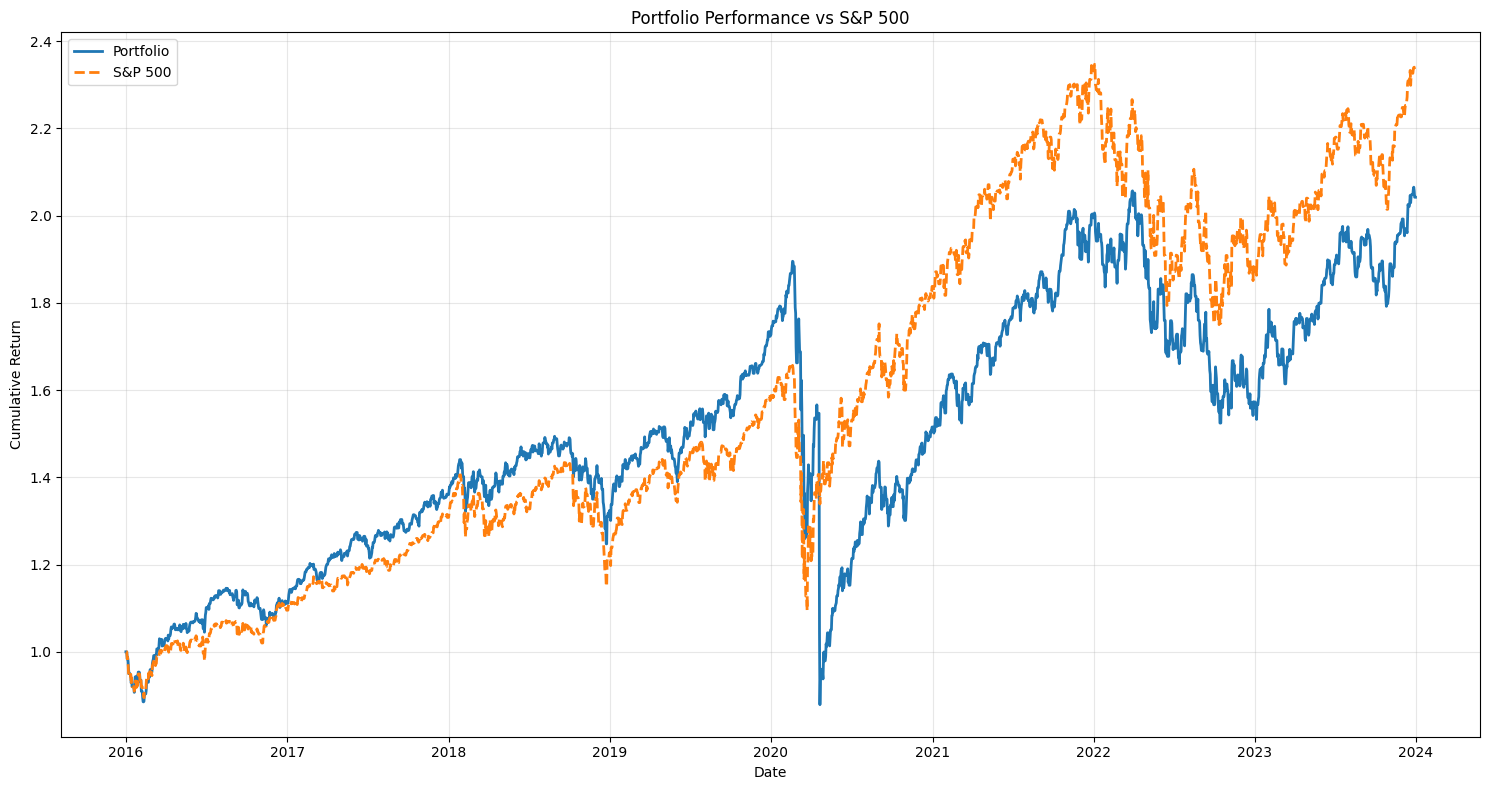

<Figure size 1500x800 with 0 Axes>

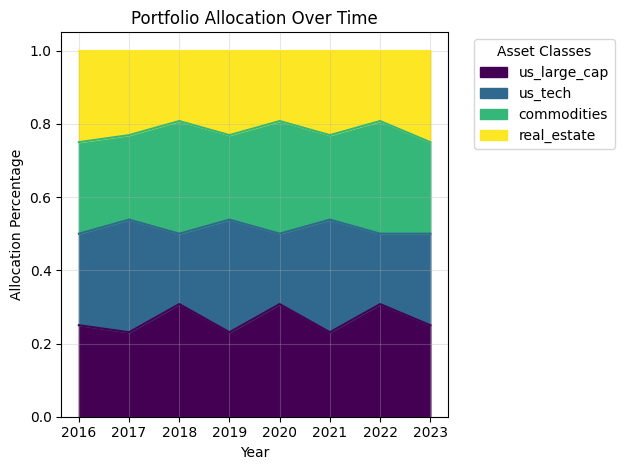

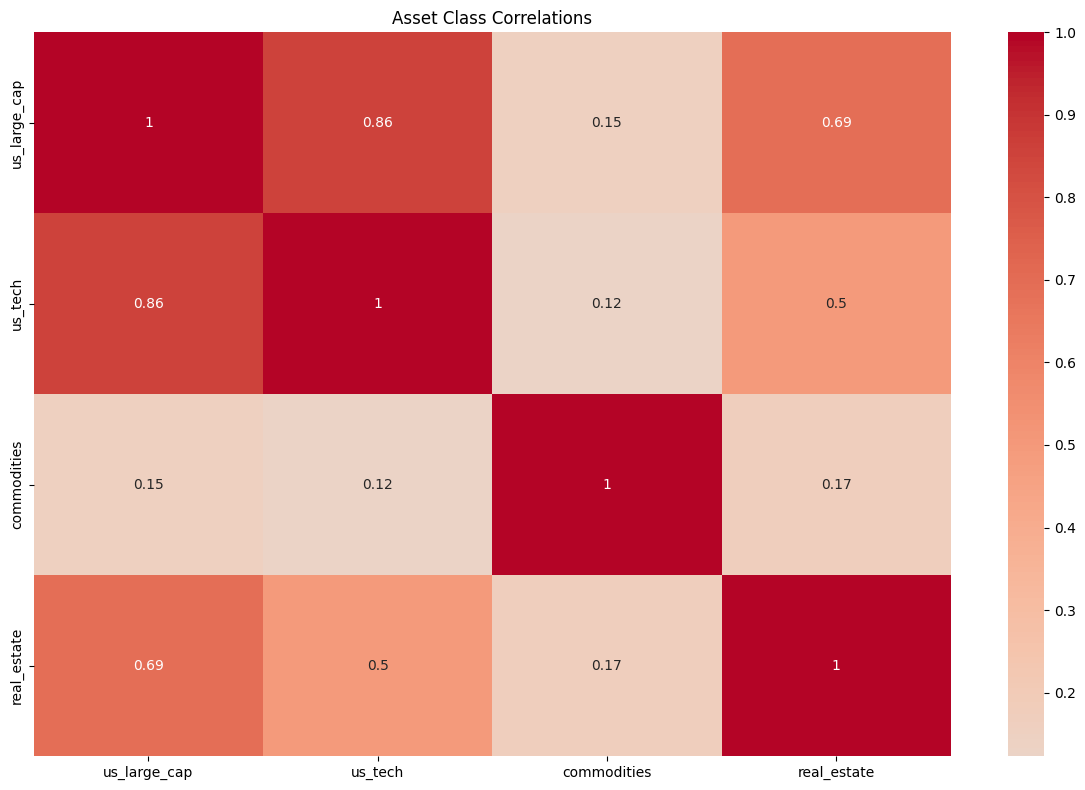

In [11]:
# 1. Portfolio Performance vs S&P 500
benchmark_returns = (1 + data['^GSPC_Close'].pct_change()).cumprod()

plt.figure(figsize=(15, 8))
plt.plot(portfolio_returns.index, portfolio_returns['Cumulative'], 
         label='Portfolio', linewidth=2)
plt.plot(data.index, benchmark_returns, 
         label='S&P 500', linewidth=2, linestyle='--')
plt.title('Portfolio Performance vs S&P 500')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Asset Allocation Over Time
plt.figure(figsize=(15, 8))
df_weights = pd.DataFrame(yearly_weights).T
df_weights.plot(kind='area', stacked=True, colormap='viridis')
plt.title('Portfolio Allocation Over Time')
plt.xlabel('Year')
plt.ylabel('Allocation Percentage')
plt.legend(title='Asset Classes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Asset Class Correlations
returns_data = pd.DataFrame()
for asset_class, assets in asset_classes.items():
    returns_data[asset_class] = data[assets].pct_change().mean(axis=1)

correlation_matrix = returns_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Asset Class Correlations')
plt.tight_layout()
plt.show()

## Results Export and Final Analysis

Save the portfolio allocations and display final performance metrics including:
- Total portfolio return
- Average annual turnover
- Other key performance indicators

In [12]:
# In your results export section (around in[18-19])
# Save results with ML insights
results = {
    'allocations': pd.DataFrame(yearly_weights).T,
    'ml_signals': ml_signals,
    'performance': portfolio_returns,
    'metrics': pd.DataFrame(yearly_metrics).T
}

# Save to separate CSV files
for name, df in results.items():
    df.to_csv(f'portfolio_{name}.csv')

print("\nAnalysis completed successfully!")
print("Results saved to:")
for name in results.keys():
    print(f"- portfolio_{name}.csv")

# Calculate total portfolio profit
total_profit = portfolio_returns['Cumulative'].iloc[-1] - 1
print(f"\nTotal Portfolio Profit: {total_profit:.2%}")

# Display final ML-enhanced metrics
print("\nML-Enhanced Portfolio Metrics:")
print("-" * 10)
for metric, value in performance_metrics.items():
    if isinstance(value, float):
        print(f"{metric:<20}: {value:>10.2%}")
    else:
        print(f"{metric:<20}: {value:>10.2f}")


Analysis completed successfully!
Results saved to:
- portfolio_allocations.csv
- portfolio_ml_signals.csv
- portfolio_performance.csv
- portfolio_metrics.csv

Total Portfolio Profit: 104.20%

ML-Enhanced Portfolio Metrics:
----------
Annual Return       :      7.95%
Annual Volatility   :     18.13%
Sharpe Ratio        :     43.86%
Sortino Ratio       :     33.76%
Max Drawdown        :    -53.64%
Win Rate            :     67.71%
Best Month          :     12.82%
Worst Month         :    -28.56%
